This notebook summarizes the pre-processing done to the data when constructing the derivative function surrogate models (DFSM).
These preprocessing steps are what happen under the hood in the class `SimulationDetails', which can be found in the DFSM package.
The three broad steps involved in constructing the DFSM are as follows:
1. Run OpenFAST simulations
2. Preprocess simulation results
3. Construct DFSM

This notebook will go over step 2, preprocessing.

There are broadly five steps to postprocessing:
1. Load OpenFAST simulations from the out/pkg file to obtain the time-series signals of key quantities.
2. Scale quantities.
3. Filter certain signals.
4. Approximate first and second-time derivatives for states.
5. Store key indices and processed signals.

We will use the simulation results in `example.outb' to illustrate the different steps in the process.
This file contains the simulation results of a load case in the rated region from DLC 1.6. 

The process aims to construct a state-space model with the following quantities.

The generator, tower fore-aft, and platform pitch degrees of freedom are enabled, so these will be the states. In addition to these, the first-time derivatives of these quantities are also included as part of the states, similar to the linearized OpenFAST models.

X = [x,dx]

dX = [dx,d2x]

The system's inputs are the rotor's average wind speed, generator torque, blade pitch, and wave elevation.

The system's outputs are the tower base-fore aft force and moment, nacelle translational and rotational acceleration, and generator power.




In [1]:
#---------------------------------------------------------------------------------------------------------------
# Step 1: Load OpenFAST simulations from the out/pkg file to obtain the time-series signals of key quantities.  
#---------------------------------------------------------------------------------------------------------------

# Import necessary libraries
import matplotlib.pyplot as plt 
import numpy as np
import os
import pickle
from scipy.interpolate import CubicSpline

# path to this directory
this_dir = os.getcwd()

# list out the states, controls and outputs
reqd_states = ['PtfmPitch','TTDspFA','GenSpeed']
reqd_controls = ['RtVAvgxh','GenTq','BldPitch1','Wave1Elev']
reqd_outputs = ['TwrBsFxt','TwrBsMyt','YawBrTAxp','NcIMURAys','GenPwr']

# outb file
outb_file = this_dir + os.sep + 'example.outb'

# import load_FAST_out from pCrunch to load the outb file
# pcrunch is available at https://github.com/NREL/pCrunch
from pCrunch.io import load_FAST_out

# load
FAST_out = load_FAST_out(outb_file)[0]

# load time
time = FAST_out['Time']

ns = len(reqd_states)
nc = len(reqd_controls)
ny = len(reqd_outputs)
nt = len(time)

# initialize storage arrays
states = np.zeros((nt,ns))
controls = np.zeros((nt,nc))
outputs = np.zeros((nt,ny))

# Loop through and extract states, controls, and outputs
for ix,state_name in enumerate(reqd_states):
    states[:,ix] = FAST_out[state_name]


for iu,control_name in enumerate(reqd_controls):
    controls[:,iu] = FAST_out[control_name]


for iy,output_name in enumerate(reqd_outputs):
    outputs[:,iy] = FAST_out[output_name]
    



Text(0.5, 0, 'Time')

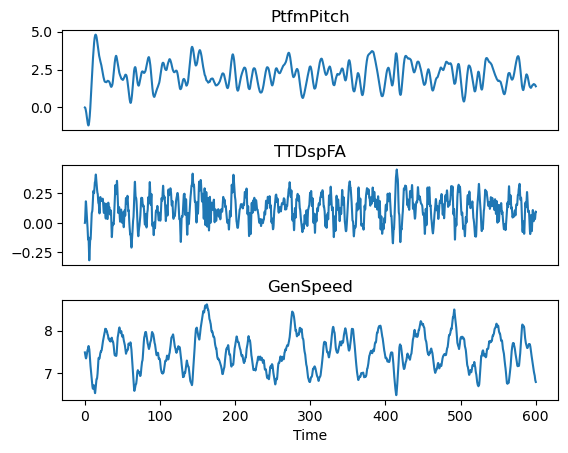

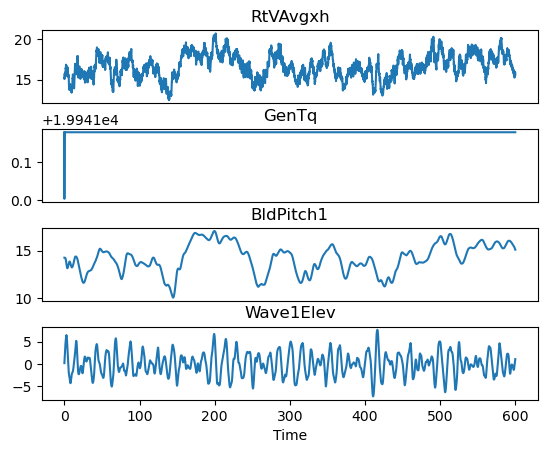

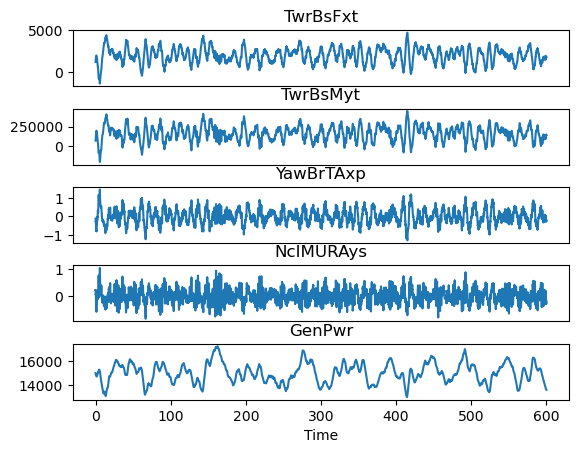

In [2]:
#plot states, controls and outputs
fig,ax = plt.subplots(ns,1)

for ix in range(ns):
    ax[ix].plot(time,states[:,ix])
    ax[ix].set_title(reqd_states[ix])
    
    if not(ix == ns-1):
        ax[ix].tick_params(
                    axis='x',          # changes apply to the x-axis
                    which='both',      # both major and minor ticks are affected
                    bottom=False,      # ticks along the bottom edge are off
                    top=False,         # ticks along the top edge are off
                    labelbottom=False) # labels along the bottom edge are off

fig.subplots_adjust(hspace = 0.35)
ax[-1].set_xlabel('Time')

# Controls
fig,ax = plt.subplots(nc,1)

for ix in range(nc):
    ax[ix].plot(time,controls[:,ix])
    ax[ix].set_title(reqd_controls[ix])
    
    if not(ix == nc-1):
        ax[ix].tick_params(
                    axis='x',          # changes apply to the x-axis
                    which='both',      # both major and minor ticks are affected
                    bottom=False,      # ticks along the bottom edge are off
                    top=False,         # ticks along the top edge are off
                    labelbottom=False) # labels along the bottom edge are off

fig.subplots_adjust(hspace = 0.35)
ax[-1].set_xlabel('Time')

# Outputs
fig,ax = plt.subplots(ny,1)

for ix in range(ny):
    ax[ix].plot(time,outputs[:,ix])
    ax[ix].set_title(reqd_outputs[ix])
    
    if not(ix == ny-1):
        ax[ix].tick_params(
                    axis='x',          # changes apply to the x-axis
                    which='both',      # both major and minor ticks are affected
                    bottom=False,      # ticks along the bottom edge are off
                    top=False,         # ticks along the top edge are off
                    labelbottom=False) # labels along the bottom edge are off

fig.subplots_adjust(hspace = 0.4)
ax[-1].set_xlabel('Time')


In [3]:
#---------------------------------------------------------------------------------------------------------------
# Step 2: Scale quantities.
#---------------------------------------------------------------------------------------------------------------

# Some quantities in states/controls/outputs can be of a different order of magnitude than others.
# These quantities can be scaled to be of the same order.
# For this example, no quantities will be scaled. Therefore the scalers will be all ones

scaler_states = np.ones((ns,))
scaler_controls = np.ones((nc,))
scaler_outputs = np.ones((ny,))

states = states/scaler_states
controls = controls/scaler_controls
outputs = outputs/scaler_outputs

In [4]:
#---------------------------------------------------------------------------------------------------------------
# Step 3: Filter quantities.
#---------------------------------------------------------------------------------------------------------------
# Some quantitites can be noisy, so these quantities can be filtered before constructing the model
# The states are all filtered slightly using 'filtfilt', with a tf of 0.1.
# This is done to help with the derivative calculation

from scipy.signal import filtfilt

def filter_signal(t_f,time,signal):

    '''
    Function to filter the given signal
    '''

    dt = time[1]-time[0]
    nb = int(np.floor(t_f/dt))
    b = np.ones((nb,))/nb;a = 1
    signal = filtfilt(b,a,signal,axis = 0)

    return signal

t_f = 0.1

# store a copy of unfiltered states
states_unfiltered = states.copy()

# loop through and filter
for ix in range(ns):
    
    states[:,ix] = filter_signal(t_f,time,states[:,ix])


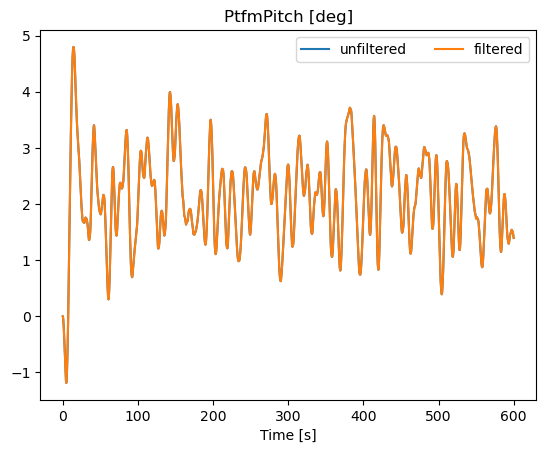

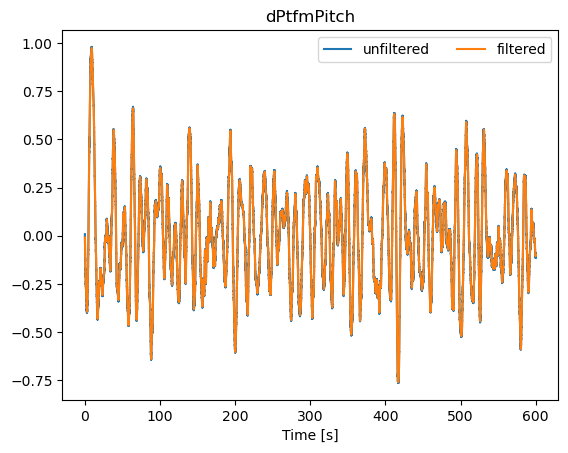

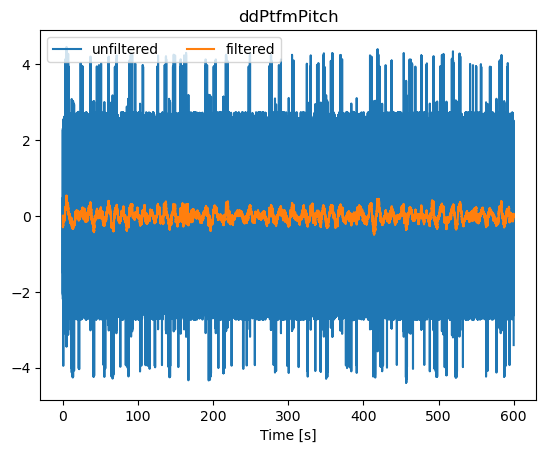

In [5]:
#---------------------------------------------------------------------------------------------------------------
# Step 4: Approximate first and second-time derivatives for states.
#---------------------------------------------------------------------------------------------------------------

# The state derivatives are calculated by constructing polynomial approximation of these states on the time esh, and evaluating 
# the state derivatives of these polynomial approximations

# construct polynomial approximation
states_pp = CubicSpline(time,states)
dx_pp = states_pp.derivative

# evaluate first time derivative
dx_pp1 = dx_pp(nu = 1)

# evaluate second time derivative
dx_pp2 = dx_pp(nu = 2)

# evaluate state derivatives
state_derivatives = dx_pp1(time)

# evaluate the second time derivatives
state_derivatives2 = dx_pp2(time)

# calculate the state derivatives for the unfiltered states

# construct polynomial approximation
states_pp_uf = CubicSpline(time,states_unfiltered)
dx_pp_uf = states_pp_uf.derivative

# evaluate first time derivative
dx_pp1_uf = dx_pp_uf(nu = 1)

# evaluate second time derivative
dx_pp2_uf = dx_pp_uf(nu = 2)

# evaluate state derivatives
state_derivatives_uf = dx_pp1_uf(time)

# evaluate the second time derivatives
state_derivatives2_uf = dx_pp2_uf(time)

# plot

fig,ax = plt.subplots(1)

ax.plot(time,states_unfiltered[:,0],label = 'unfiltered')
ax.plot(time,states[:,0],label = 'filtered')
ax.set_xlabel('Time [s]')
ax.set_title('PtfmPitch [deg]')
ax.legend(ncol = 2)

fig,ax = plt.subplots(1)

ax.plot(time,state_derivatives_uf[:,0],label = 'unfiltered')
ax.plot(time,state_derivatives[:,0],label = 'filtered')
ax.set_xlabel('Time [s]')
ax.set_title('dPtfmPitch')
ax.legend(ncol = 2)

fig,ax = plt.subplots(1)

ax.plot(time,state_derivatives2_uf[:,0],label = 'unfiltered')
ax.plot(time,state_derivatives2[:,0],label = 'filtered')
ax.set_xlabel('Time [s]')
ax.set_title('ddPtfmPitch')
ax.legend(ncol = 2)

# From the plots, its clear that filtering the states help when calculating the state derivatives

In the final step, the indices for some key quantities are stored


In [6]:
blade_pitch_ind = reqd_controls.index('BldPitch1')